<a href="https://colab.research.google.com/github/EricEricEricJin/ECE539-Group-Project/blob/master/pre_vis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
####################
# Import libraries #
####################

from google.colab import drive
drive.mount("/content/drive")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras

import IPython

import os
import datetime

Mounted at /content/drive


In [ ]:
DIR_NAME = "/content/drive/My Drive/Colab Notebooks/ECE539_Project/"

In [ ]:
#############################
# Load xxm_splitted dataset #
#############################

def get_waveforms_labels(fp, INPUT_SIZE):
  def _get_waveform(file_path):
    audio_binary = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio)

  def _get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2]

  waveforms = []
  labels = []
  for dirname, _, filenames in os.walk(fp):
      if "xxm_singing" in dirname or "xxm_speech" in dirname:
          print(dirname, filenames)
          for filename in filenames:
            filepath = os.path.join(dirname, filename)
            for i in range(661500 // INPUT_SIZE):
              waveforms.append(_get_waveform(filepath)[i*INPUT_SIZE : (i+1)*INPUT_SIZE])
              labels.append(_get_label(filepath))
  return waveforms, labels

CHUNK_SAMPLE = 661500 // 5

fp = "/content/drive/My Drive/Colab Notebooks/ECE539_Project"
categories = ["xxm_speech", "xxm_singing"]
waveforms, labels = get_waveforms_labels(fp, CHUNK_SAMPLE)

# Merge to tfds
# _ds = tf.data.Dataset.from_tensor_slices((waveforms, labels))
# waveform_ds = _ds.shuffle(buffer_size=len(_ds))
# waveform_ds = _ds

/content/drive/My Drive/Colab Notebooks/ECE539_Project/xxm_speech ['3_13.wav', '29_14.wav', '7_6.wav', '28_6.wav', '19_1.wav', '8_9.wav', '25_8.wav', '20_13.wav', '3_16.wav', '5_7.wav', '26_4.wav', '5_4.wav', '15_8.wav', '15_14.wav', '7_3.wav', '17_17.wav', '18_9.wav', '25_2.wav', '8_2.wav', '8_6.wav', '11_24.wav', '13_13.wav', '5_1.wav', '11_16.wav', '24_2.wav', '13_10.wav', '3_12.wav', '26_7.wav', '26_10.wav', '6_5.wav', '29_23.wav', '0_2.wav', '19_3.wav', '0_3.wav', '0_0.wav', '0_6.wav', '13_1.wav', '7_9.wav', '11_5.wav', '2_1.wav', '25_5.wav', '15_12.wav', '0_22.wav', '11_23.wav', '0_11.wav', '11_3.wav', '6_6.wav', '26_8.wav', '29_18.wav', '0_10.wav', '18_3.wav', '3_11.wav', '13_8.wav', '7_7.wav', '24_9.wav', '23_2.wav', '19_2.wav', '3_2.wav', '27_4.wav', '22_2.wav', '15_7.wav', '20_7.wav', '6_0.wav', '25_4.wav', '29_11.wav', '6_7.wav', '18_11.wav', '7_2.wav', '7_10.wav', '3_17.wav', '17_3.wav', '3_14.wav', '11_11.wav', '0_17.wav', '24_11.wav', '24_24.wav', '10_8.wav', '24_17.wav',

In [ ]:
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128)
    # removes the phase (we only care about the magnitude)
    spectrogram = tf.abs(spectrogram)
    return spectrogram

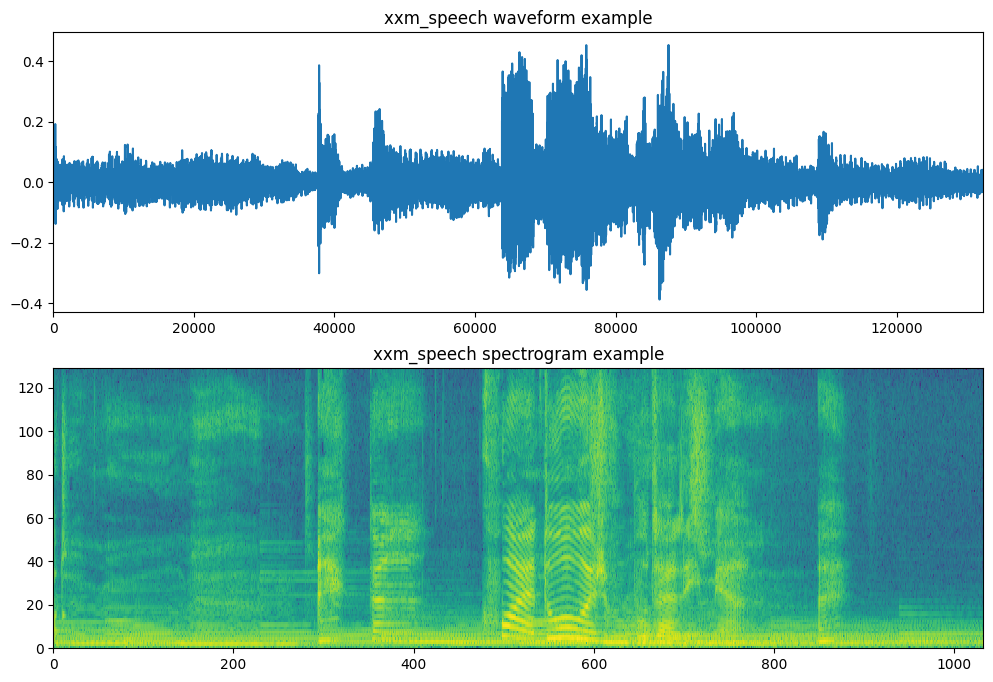

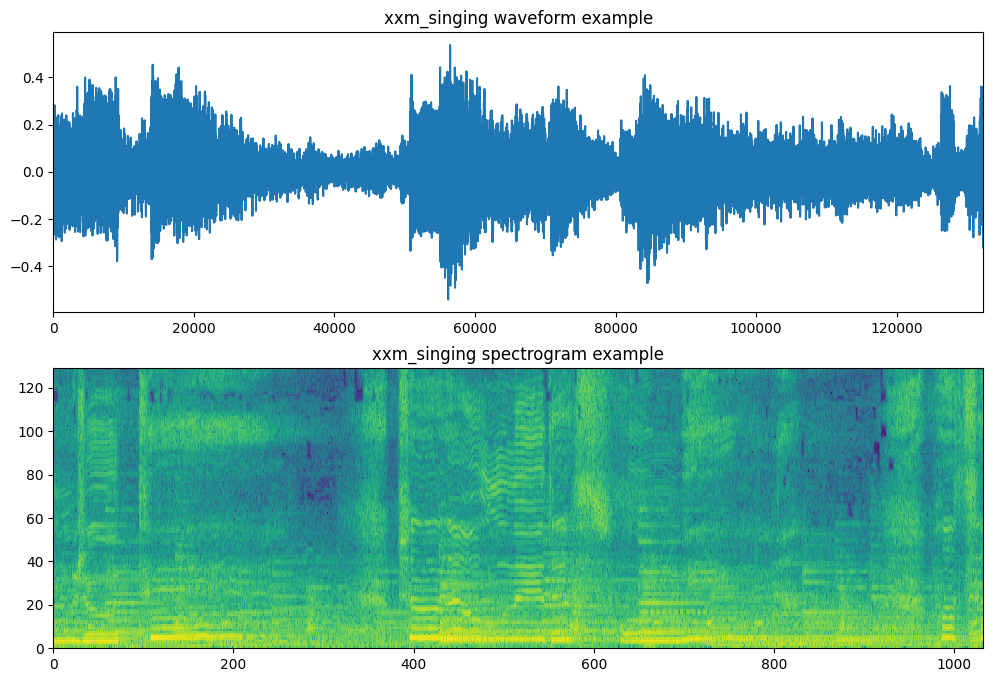

In [ ]:
ex_speech_idx = 32
ex_speech_audio = waveforms[ex_speech_idx]
ex_speech_label = labels[ex_speech_idx]

ex_singing_idx = len(labels) //2 + 170
ex_singing_audio = waveforms[ex_singing_idx]
ex_singing_label = labels[ex_singing_idx]

for audio, label in [(ex_speech_audio, ex_speech_label), (ex_singing_audio, ex_singing_label)]:

  fig, axes = plt.subplots(2, figsize=(12, 8))
  timescale = np.arange(len(audio))
  axes[0].plot(timescale, audio)
  axes[0].set_title(f'{label.numpy().decode()} waveform example')
  axes[0].set_xlim([0, len(audio)])

  spectrogram = get_spectrogram(audio)
  log_spec = np.log(spectrogram.numpy().T)
  axes[1].pcolormesh(log_spec)
  axes[1].set_title(f'{label.numpy().decode()} spectrogram example')
  plt.show()

  ret = IPython.display.Audio(audio, rate=22050)
  IPython.display.display(ret)


In [ ]:
SAMPLE_RATE = 22050


CHUNK_SAMPLE = 661500 // 5

# Load model
model = keras.models.load_model(DIR_NAME + f"ms_clf_weights_N={CHUNK_SAMPLE}")
model.summary()

def evaluate_stream(BV, STEP_SIZE):
  # Load audio file and parse marker file
  wav_filepath = DIR_NAME + f"xxm_mixed/{BV}.wav"
  audio_binary = tf.io.read_file(wav_filepath)
  marker = np.loadtxt(
    DIR_NAME + f"xxm_mixed/{BV}.csv",
    delimiter=',')
  marker = marker[:,0] * 3600 + marker[:,1] * 60 + marker[:,2]

  # Decode audio and transform to spectrograms
  audio, _ = tf.audio.decode_wav(audio_binary)
  waveform = tf.squeeze(audio)

  def get_spectrogram(waveform):
      spectrogram = tf.signal.stft(
          waveform, frame_length=255, frame_step=128)
      # removes the phase (we only care about the magnitude)
      spectrogram = tf.abs(spectrogram)
      return spectrogram

  pred_list = []
  model_input_list = []

  for i in range((len(waveform) - CHUNK_SAMPLE) // STEP_SIZE + 1):
    wave_ith = waveform[i * STEP_SIZE : i * STEP_SIZE + CHUNK_SAMPLE]
    model_input_list.append(tf.expand_dims(get_spectrogram(wave_ith), -1))

  # Use model to predict
  input_shape = model_input_list[0].shape
  pred_list = model.predict(tf.reshape(model_input_list, (len(model_input_list), *input_shape)))
  return marker, pred_list

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 512, 64, 1)        0         
                                                                 
 normalization (Normalizati  (None, 512, 64, 1)        3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 510, 62, 32)       320       
                                                                 
 conv2d_1 (Conv2D)           (None, 508, 60, 64)       18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 254, 30, 64)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 254, 30, 64)       0

In [ ]:
STEP_SIZE = CHUNK_SAMPLE // 2

marker, pred_list = evaluate_stream("BV15z4y1M7ee", STEP_SIZE)
pred_1D = pred_list[:,1] - pred_list[:,0]

# pred_1D

81/81 [==============================] - 96s 1s/step


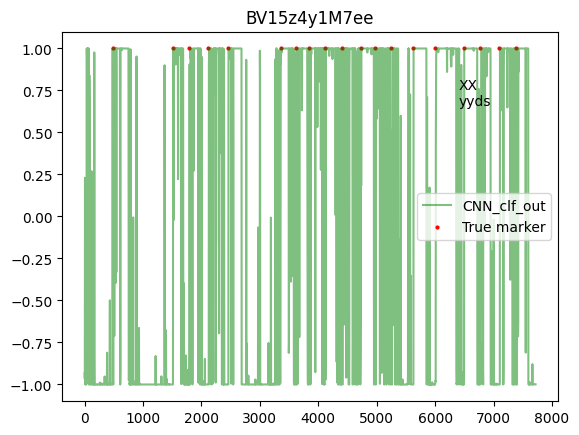

In [ ]:
plt.title("BV15z4y1M7ee")
plt.plot(np.linspace(0, (len(pred_1D)-1) * STEP_SIZE / SAMPLE_RATE, len(pred_1D)), pred_1D, c='g', alpha=0.5, label="CNN_clf_out")
plt.scatter(marker, np.ones(len(marker)), s=4, c='r', label="True marker")
plt.legend()
plt.show()

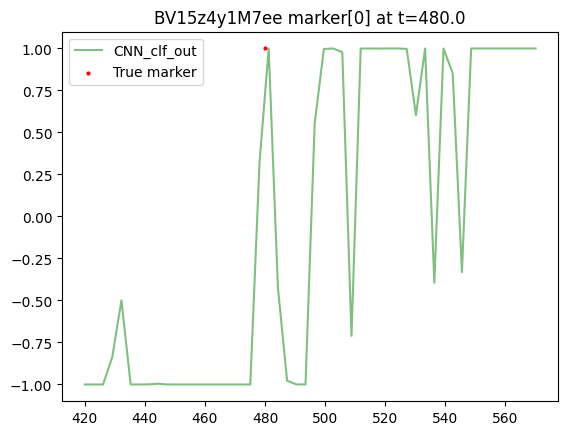

In [ ]:
start_idx = int((marker[0]-60) * SAMPLE_RATE / STEP_SIZE)
end_idx = int((marker[0]+90) * SAMPLE_RATE / STEP_SIZE)
pred_m0 = pred_1D[start_idx : end_idx]
plt.title(f"BV15z4y1M7ee marker[0] at t={marker[0]}")
plt.plot(np.linspace(marker[0] - 60, marker[0] + 90, len(pred_m0)), pred_m0, c='g', alpha=0.5, label="CNN_clf_out")
plt.scatter(marker[0], 1, s=4, c='r', label="True marker")
plt.legend()
plt.show()

In [ ]:
negative_input = np.load(os.path.join(DIR_NAME, "pred_series/speech/BV15z4y1M7ee.npy"))
marker, negative_input[0]

NameError: ignored

### Visualize outcome

In [ ]:
def sensitivity(TP, FP, FN): return TP / (TP + FN)
def miss_ratio(TP, FP, FN): return FN / (TP+FN)
def precision(TP, FP, FN): return TP / (TP + FP)
# TP, FP, FN
outcome_dict = {}
outcome_arr = []
for row in np.load(os.path.join(DIR_NAME, "slicer_outcome.npy")):
  outcome_dict.update({row[0]: [int(row[i]) for i in range(1, len(row))]})
  outcome_arr.append([row[0], *[int(row[i]) for i in range(1, len(row))]])

for row in outcome_arr:
  TP_FP_FN = row[1:4]
  row.extend([sensitivity(*TP_FP_FN), miss_ratio(*TP_FP_FN), precision(*TP_FP_FN)])

outcome_arr.append(["Overall", *[sum( list(zip(*outcome_arr))[i] ) for i in range(1, 4)]])
total_TP_FP_FN = outcome_arr[-1][1:4]
outcome_arr[-1].extend([sensitivity(*total_TP_FP_FN), miss_ratio(*total_TP_FP_FN), precision(*total_TP_FP_FN)])
outcome_dict, outcome_arr

({'BV1Gh4y1i7dv': [9, 5, 0],
  'BV1ye411X7AP': [11, 1, 0],
  'BV1n24y1t7Xb': [16, 6, 0],
  'BV1os4y1J7TK': [16, 7, 0],
  'BV1Hw411z7Sv': [15, 5, 1],
  'BV1JN4y1U7ba': [12, 3, 0],
  'BV1gu4y1Q7V2': [16, 18, 0],
  'BV1CL411q77Y': [14, 11, 2]},
 [['BV1Gh4y1i7dv', 9, 5, 0, 1.0, 0.0, 0.6428571428571429],
  ['BV1ye411X7AP', 11, 1, 0, 1.0, 0.0, 0.9166666666666666],
  ['BV1n24y1t7Xb', 16, 6, 0, 1.0, 0.0, 0.7272727272727273],
  ['BV1os4y1J7TK', 16, 7, 0, 1.0, 0.0, 0.6956521739130435],
  ['BV1Hw411z7Sv', 15, 5, 1, 0.9375, 0.0625, 0.75],
  ['BV1JN4y1U7ba', 12, 3, 0, 1.0, 0.0, 0.8],
  ['BV1gu4y1Q7V2', 16, 18, 0, 1.0, 0.0, 0.47058823529411764],
  ['BV1CL411q77Y', 14, 11, 2, 0.875, 0.125, 0.56],
  ['Overall',
   109,
   56,
   3,
   0.9732142857142857,
   0.026785714285714284,
   0.6606060606060606]])

In [ ]:
from tabulate import tabulate

print(tabulate(outcome_arr, headers=["BV", "TP", "FP", "FN", "Sensitivity", "Miss ratio", "Precision"]))

BV              TP    FP    FN    Sensitivity    Miss ratio    Precision
------------  ----  ----  ----  -------------  ------------  -----------
BV1Gh4y1i7dv     9     5     0       1            0             0.642857
BV1ye411X7AP    11     1     0       1            0             0.916667
BV1n24y1t7Xb    16     6     0       1            0             0.727273
BV1os4y1J7TK    16     7     0       1            0             0.695652
BV1Hw411z7Sv    15     5     1       0.9375       0.0625        0.75
BV1JN4y1U7ba    12     3     0       1            0             0.8
BV1gu4y1Q7V2    16    18     0       1            0             0.470588
BV1CL411q77Y    14    11     2       0.875        0.125         0.56
Overall        109    56     3       0.973214     0.0267857     0.660606


In [ ]:

def get_series_labels():
  positive = 0
  negative = 0

  series = []
  labels = []
  for dirname, _, filenames in os.walk(DIR_NAME + "pred_series"):
    if ("singing" in dirname or "speech" in dirname):
      for filename in filenames:
        for row in np.load(os.path.join(dirname, filename)):
          series.append(row)
          labels.append([0, 1] if "singing" in dirname else [1, 0])
          if ("singing" in dirname):
            positive += 1
          else:
            negative += 1
  print("# of positive data", positive)
  print("# of negative data", negative)
  return series, labels

series, labels = get_series_labels()
series_ds = tf.data.Dataset.from_tensor_slices((series, labels))
print("Number of data", len(series_ds))

# of positive data 175
# of negative data 175
Number of data 350


In [ ]:
for _ in series_ds.take(1):
  print(_[0].shape, _[1])

(50,) tf.Tensor([0 1], shape=(2,), dtype=int32)
